# MC ε-贪心算法教程：更实用的蒙特卡洛方法

## 📖 为什么需要 MC ε-贪心？

在 `MC Basic` 算法中，我们学习了蒙特卡洛方法的基本原理。但它有一个很强的假设：**探索性起点 (Exploring Starts)**。这意味着为了评估所有状态-动作对，我们需要从每一个可能的 (s,a) 对开始生成回合。

在现实世界中，这个假设往往难以满足。例如，在机器人控制任务中，我们可能无法随意设置机器人的初始状态和初始动作。

**MC ε-贪心算法**通过引入“探索”机制解决了这个问题，使其更加实用：

- **无需探索性起点**：通过 ε-贪心策略在学习过程中进行探索。
- **平衡探索与利用**：以 1-ε 的概率选择当前最优动作（利用），以 ε 的概率随机选择一个动作（探索）。
- **在线策略 (On-policy)**：用于生成数据的策略和被评估改进的策略是同一个。
- **保证收敛**：在一定条件下，它能收敛到最优策略。

## 🎯 本教程目标

我们将从零开始实现 MC ε-贪心算法，并在同一个 4×4 网格世界中进行可视化：

- **核心内容**：
  - 理解 ε-贪心策略如何平衡探索与利用。
  - 实现基于回合采样的 on-policy 蒙特卡洛控制。
  - 可视化 Q 值和策略在探索中的收敛过程。

- **学习路径**：
  1. 理解 ε-贪心策略。
  2. 构建支持随机起始回合的环境。
  3. 实现 MC ε-贪心核心算法。
  4. 可视化学习过程（GIF 动画）。
  5. 分析与 MC Basic 的异同。

---

让我们开始探索这种更强大的无模型学习方法！

## 第一步：安装和导入必要的库

In [1]:
# 导入必要的库
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from typing import Optional, Tuple, Dict, Any, List
from collections import defaultdict

# 设置 matplotlib 后端（必须在导入 pyplot 之前）
import matplotlib
matplotlib.use('Agg')  # 使用非交互式后端，适合云端环境

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, clear_output, Image as IPImage
import imageio
from io import BytesIO

# 配置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False

print(f"✅ Gymnasium 版本: {gym.__version__}")
print(f"✅ NumPy 版本: {np.__version__}")
print(f"✅ Matplotlib 版本: {matplotlib.__version__}")
print(f"✅ Matplotlib 后端: {matplotlib.get_backend()}")
print(f"✅ 中文字体配置完成")
print(f"✅ imageio 已导入，支持 GIF 动画生成")

✅ Gymnasium 版本: 1.2.1
✅ NumPy 版本: 2.3.3
✅ Matplotlib 版本: 3.10.7
✅ Matplotlib 后端: Agg
✅ 中文字体配置完成
✅ imageio 已导入，支持 GIF 动画生成


## 第二步：创建支持 MC 学习的网格世界环境

为了适应 ε-贪心算法，我们需要对环境做一些微调。主要区别在于回合的生成方式：

- **随机起点**：回合可以从任意非终止状态随机开始。
- **策略驱动**：整个回合都由一个给定的策略（即 ε-贪心策略）驱动。

In [2]:
class GridWorldEpsilonGreedy(gym.Env):
    """支持 MC ε-贪心学习的网格世界环境"""
    
    def __init__(self, size: int = 4, rewards: np.ndarray = None):
        super().__init__()
        self.size = size
        
        # 设置奖励矩阵
        if rewards is None:
            self.rewards = np.array([
                [0, 0, -1, -1],
                [0, -1, -1, 1],
                [0, -1, 0, 0],
                [-1, 0, 0, -1]
            ])
        else:
            self.rewards = rewards
        
        # 目标位置和障碍物位置
        self.target_pos = np.argwhere(self.rewards == 1)[0]
        self.obstacle_mask = (self.rewards == -1)
        
        # 动作空间：0=上, 1=下, 2=左, 3=右
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(size * size)
        
        # 动作映射
        self._action_to_direction = {
            0: np.array([-1, 0]),  # 上
            1: np.array([1, 0]),   # 下
            2: np.array([0, -1]),  # 左
            3: np.array([0, 1]),   # 右
        }
        
        self._agent_location = np.array([0, 0])
    
    def _pos_to_state(self, pos):
        return pos[0] * self.size + pos[1]
    
    def _state_to_pos(self, state):
        return np.array([state // self.size, state % self.size])
    
    def reset(self, start_pos: Optional[np.ndarray] = None):
        """重置环境，可以指定或随机选择起始位置"""
        if start_pos is not None:
            self._agent_location = np.array(start_pos)
        else:
            # 随机选择一个非终止、非障碍的起始位置
            while True:
                pos = np.random.randint(0, self.size, size=2)
                if not np.array_equal(pos, self.target_pos) and not self.obstacle_mask[pos[0], pos[1]]:
                    self._agent_location = pos
                    break
        
        state = self._pos_to_state(self._agent_location)
        return state, {}
    
    def step(self, action: int):
        direction = self._action_to_direction[action]
        new_location = self._agent_location + direction
        
        if (0 <= new_location[0] < self.size and 0 <= new_location[1] < self.size):
            self._agent_location = new_location
        
        reward = self.rewards[self._agent_location[0], self._agent_location[1]]
        terminated = np.array_equal(self._agent_location, self.target_pos)
        state = self._pos_to_state(self._agent_location)
        return state, reward, terminated, False, {}
    
    def generate_episode(self, policy: np.ndarray, max_steps: int = 100):
        """从随机状态开始，根据策略生成一个完整的回合"""
        state, _ = self.reset() # 随机起点
        episode = []
        
        for _ in range(max_steps):
            action = np.random.choice(self.action_space.n, p=policy[state])
            next_state, reward, terminated, _, _ = self.step(action)
            episode.append((state, action, reward))
            if terminated:
                break
            state = next_state
        
        return episode

# 创建环境实例
env = GridWorldEpsilonGreedy(size=4)
print(f"✅ GridWorldEpsilonGreedy 环境创建完成")
print(f"   - 网格大小: {env.size}×{env.size}")
print(f"   - 动作空间: {env.action_space} (0=上, 1=下, 2=左, 3=右)")
print(f"   - 目标位置: {env.target_pos}")
print(f"\n   奖励矩阵:")
print(env.rewards)

✅ GridWorldEpsilonGreedy 环境创建完成
   - 网格大小: 4×4
   - 动作空间: Discrete(4) (0=上, 1=下, 2=左, 3=右)
   - 目标位置: [1 3]

   奖励矩阵:
[[ 0  0 -1 -1]
 [ 0 -1 -1  1]
 [ 0 -1  0  0]
 [-1  0  0 -1]]


## 第三步：理解 MC ε-贪心算法

### 🧮 ε-贪心策略

为了确保在学习过程中有足够的探索，我们使用 **ε-贪心策略**。对于任意状态 $s$，策略 $\pi$ 定义如下：

$$
\pi(a|s) = 
\begin{cases} 
1 - \epsilon + \frac{\epsilon}{|\mathcal{A}(s)|} & \text{if } a = \arg\max_{a'} Q(s,a') \\ 
\frac{\epsilon}{|\mathcal{A}(s)|} & \text{if } a \neq \arg\max_{a'} Q(s,a') 
\end{cases}
$$

其中：
- $1 - \epsilon$ 是“利用”的概率，即选择当前估计的最好动作。
- $\epsilon$ 是“探索”的概率，即随机选择一个动作。
- $|\mathcal{A}(s)|$ 是状态 $s$ 下的动作数量。

### 🔄 On-Policy MC Control 算法流程

**初始化**：
- 随机初始化 $Q(s,a)$。
- 初始化 `returns(s,a)` 为空列表。
- 根据初始 Q 值创建一个 ε-贪心策略 $\pi$。

**循环（直到收敛或达到最大回合数）：**

1. **生成回合**：使用当前策略 $\pi$ 从一个随机起点生成一个完整的回合。
   - `(S_0, A_0, R_1), (S_1, A_1, R_2), ..., (S_{T-1}, A_{T-1}, R_T)`

2. **计算回报**：对于回合中每个时间步 $t=0, 1, ..., T-1$：
   - 计算从该步开始的折扣回报 $G_t = R_{t+1} + \gamma R_{t+2} + ...$

3. **更新 Q 值**：对于回合中出现的每一个状态-动作对 $(S_t, A_t)$：
   - 将回报 $G_t$ 添加到 `returns(S_t, A_t)` 列表中。
   - 更新 $Q(S_t, A_t)$ 为 `returns(S_t, A_t)` 的平均值。

4. **更新策略**：根据更新后的 Q 值，改进 ε-贪心策略 $\pi$。

## 第四步：定义算法参数

In [3]:
# --- 算法参数 ---
GRID_SIZE = 4           # 网格大小
GAMMA = 0.9             # 折扣因子
EPSILON = 0.1           # ε-贪心策略中的 ε 值
NUM_EPISODES = 5000     # 总共要运行的回合数
MAX_STEPS = 100         # 每个回合的最大步数

# 动作名称（用于可视化）
ACTION_NAMES = ['↑', '↓', '←', '→']

print(f"✅ 算法参数配置完成")
print(f"   - 网格大小: {GRID_SIZE}×{GRID_SIZE}")
print(f"   - 折扣因子 γ: {GAMMA}")
print(f"   - Epsilon ε: {EPSILON}")
print(f"   - 总回合数: {NUM_EPISODES}")
print(f"   - 动作空间: {ACTION_NAMES}")

✅ 算法参数配置完成
   - 网格大小: 4×4
   - 折扣因子 γ: 0.9
   - Epsilon ε: 0.1
   - 总回合数: 5000
   - 动作空间: ['↑', '↓', '←', '→']


## 第五步：实现 MC ε-贪心核心算法

In [4]:
def create_epsilon_greedy_policy(Q: np.ndarray, epsilon: float, num_actions: int) -> np.ndarray:
    """根据 Q 值创建一个 ε-贪心策略"""
    num_states = Q.shape[0]
    policy = np.ones((num_states, num_actions)) * epsilon / num_actions
    
    for state in range(num_states):
        best_action = np.argmax(Q[state])
        policy[state, best_action] += (1.0 - epsilon)
    
    return policy

def get_policy_matrix(policy: np.ndarray, grid_size: int) -> np.ndarray:
    """将策略转换为箭头矩阵用于可视化"""
    policy_arrows = np.empty((grid_size, grid_size), dtype=object)
    
    for state in range(grid_size * grid_size):
        row = state // grid_size
        col = state % grid_size
        best_action = np.argmax(policy[state])
        policy_arrows[row, col] = ACTION_NAMES[best_action]
    
    return policy_arrows

print("✅ MC ε-贪心核心函数定义完成")

✅ MC ε-贪心核心函数定义完成


## 第六步：实现可视化函数

可视化函数与 `MC Basic` 基本相同，但标题和迭代计数方式有所调整，以反映是基于回合数进行更新。

In [5]:
def render_mc_epsilon_greedy_to_array(rewards, Q, policy_arrows, episode_num):
    """
    将当前 MC ε-贪心状态渲染为 RGB 数组（用于 GIF 生成）
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
    
    # 配色方案
    reward_cmap = LinearSegmentedColormap.from_list('reward', ['red', 'white', 'green'])
    value_cmap = 'viridis'
    
    # 1. 绘制奖励矩阵
    ax1 = axes[0]
    im1 = ax1.imshow(rewards, cmap=reward_cmap, vmin=-1, vmax=1)
    ax1.set_title(f'Reward Matrix', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(GRID_SIZE))
    ax1.set_yticks(range(GRID_SIZE))
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            ax1.text(j, i, f'{rewards[i, j]:.0f}',
                    ha="center", va="center", color="black", fontsize=12)
    
    plt.colorbar(im1, ax=ax1, fraction=0.046)
    
    # 2. 绘制 Q 值矩阵（显示最大 Q 值）
    ax2 = axes[1]
    Q_max = Q.reshape(GRID_SIZE, GRID_SIZE, 4).max(axis=2)
    im2 = ax2.imshow(Q_max, cmap=value_cmap)
    ax2.set_title(f'Q-Value Matrix (max) - Episode {episode_num}', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(GRID_SIZE))
    ax2.set_yticks(range(GRID_SIZE))
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            ax2.text(j, i, f'{Q_max[i, j]:.2f}',
                    ha="center", va="center", 
                    color="white" if Q_max[i, j] < (Q_max.max()/2 if Q_max.max() > 0 else 0.5) else "black",
                    fontsize=10)
    
    plt.colorbar(im2, ax=ax2, fraction=0.046)
    
    # 3. 绘制策略矩阵
    ax3 = axes[2]
    policy_display = np.zeros((GRID_SIZE, GRID_SIZE))
    im3 = ax3.imshow(policy_display, cmap='gray', vmin=0, vmax=1, alpha=0.1)
    ax3.set_title(f'Policy Matrix - Episode {episode_num}', fontsize=14, fontweight='bold')
    ax3.set_xticks(range(GRID_SIZE))
    ax3.set_yticks(range(GRID_SIZE))
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if policy_arrows[i, j]:
                ax3.text(j, i, policy_arrows[i, j],
                        ha="center", va="center", 
                        color="blue", fontsize=24, fontweight='bold')
    
    # 整体标题
    fig.suptitle(f'MC ε-Greedy Algorithm: Episode {episode_num}', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    # 转换为 RGB 数组
    fig.canvas.draw()
    buf = fig.canvas.buffer_rgba()
    rgb_array = np.asarray(buf)
    rgb_array = rgb_array[:, :, :3]  # RGBA to RGB
    plt.close(fig)
    
    return rgb_array

print("✅ 可视化函数定义完成")

✅ 可视化函数定义完成


## 第七步：执行 MC ε-贪心算法并生成 GIF 动画

                            🚀 MC ε-贪心算法启动                             
生成第 1 回合的帧...
生成第 50 回合的帧...
生成第 100 回合的帧...
生成第 150 回合的帧...
生成第 200 回合的帧...
生成第 250 回合的帧...
生成第 300 回合的帧...
生成第 350 回合的帧...
生成第 400 回合的帧...
生成第 450 回合的帧...
生成第 500 回合的帧...
生成第 550 回合的帧...
生成第 600 回合的帧...
生成第 650 回合的帧...
生成第 700 回合的帧...
生成第 750 回合的帧...
生成第 800 回合的帧...
生成第 850 回合的帧...
生成第 900 回合的帧...
生成第 950 回合的帧...
生成第 1000 回合的帧...
生成第 1050 回合的帧...
生成第 1100 回合的帧...
生成第 1150 回合的帧...
生成第 1200 回合的帧...
生成第 1250 回合的帧...
生成第 1300 回合的帧...
生成第 1350 回合的帧...
生成第 1400 回合的帧...
生成第 1450 回合的帧...
生成第 1500 回合的帧...
生成第 1550 回合的帧...
生成第 1600 回合的帧...
生成第 1650 回合的帧...
生成第 1700 回合的帧...
生成第 1750 回合的帧...
生成第 1800 回合的帧...
生成第 1850 回合的帧...
生成第 1900 回合的帧...
生成第 1950 回合的帧...
生成第 2000 回合的帧...
生成第 2050 回合的帧...
生成第 2100 回合的帧...
生成第 2150 回合的帧...
生成第 2200 回合的帧...
生成第 2250 回合的帧...
生成第 2300 回合的帧...
生成第 2350 回合的帧...
生成第 2400 回合的帧...
生成第 2450 回合的帧...
生成第 2500 回合的帧...
生成第 2550 回合的帧...
生成第 2600 回合的帧...
生成第 2650 回合的帧...
生成第 2700 回合的帧...
生成第 2750 回合的帧...


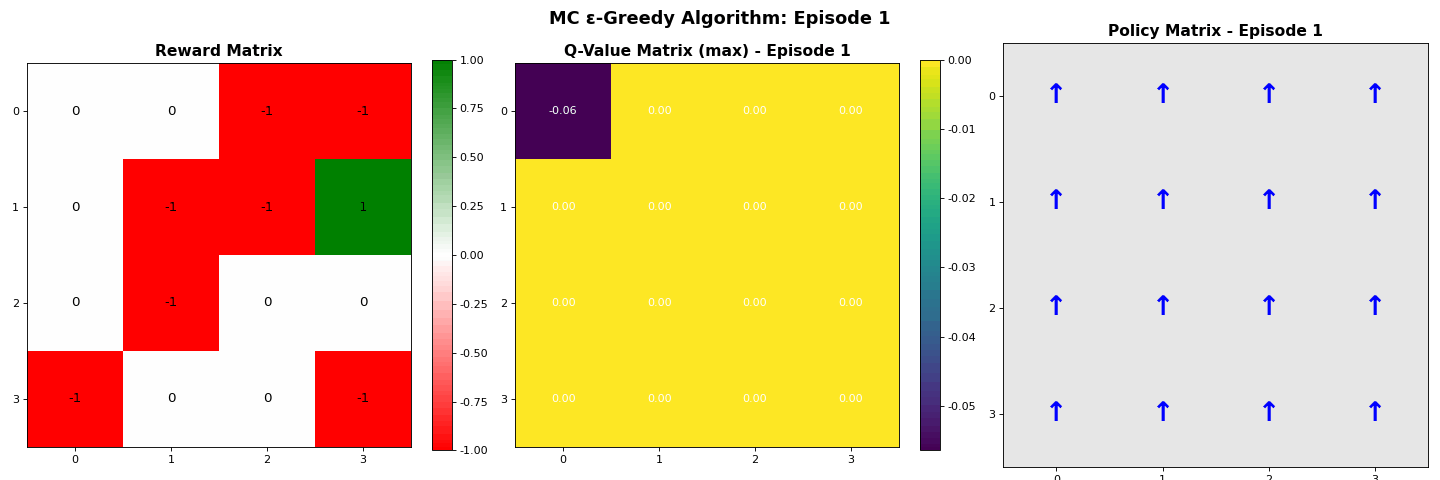

In [6]:
def run_mc_epsilon_greedy(gif_filename='mc_epsilon_greedy.gif', fps=10):
    """
    执行 MC ε-贪心算法并生成 GIF 动画
    """
    print("=" * 70)
    print("🚀 MC ε-贪心算法启动".center(70))
    print("=" * 70)
    
    # 初始化
    num_states = GRID_SIZE * GRID_SIZE
    num_actions = 4
    
    Q = np.zeros((num_states, num_actions))
    returns = defaultdict(list)
    
    frames = []
    frame_interval = NUM_EPISODES // 100  # 每隔多少回合保存一帧
    
    # MC ε-贪心主循环
    for i in range(1, NUM_EPISODES + 1):
        # 1. 创建/更新 ε-贪心策略
        policy = create_epsilon_greedy_policy(Q, EPSILON, num_actions)
        
        # 2. 生成一个回合
        episode = env.generate_episode(policy, MAX_STEPS)
        
        # 3. 计算回报并更新 Q 值
        G = 0
        visited_sa_pairs = set()
        
        # 从后向前遍历回合
        for state, action, reward in reversed(episode):
            G = reward + GAMMA * G
            sa_pair = (state, action)
            
            # 首次访问 (First-visit) MC
            if sa_pair not in visited_sa_pairs:
                returns[sa_pair].append(G)
                Q[state, action] = np.mean(returns[sa_pair])
                visited_sa_pairs.add(sa_pair)
        
        # 4. 定期生成并保存帧
        if i % frame_interval == 0 or i == 1:
            policy_arrows = get_policy_matrix(policy, GRID_SIZE)
            print(f"生成第 {i} 回合的帧...")
            frames.append(render_mc_epsilon_greedy_to_array(env.rewards, Q, policy_arrows, i))
    
    print(f"\n{'=' * 70}")
    print("🎉 MC ε-贪心算法完成！".center(70))
    print(f"{'=' * 70}")
    print(f"✅ 总计回合数: {NUM_EPISODES}")
    
    # 在结尾多添加几帧以便观察最终结果
    policy_arrows = get_policy_matrix(create_epsilon_greedy_policy(Q, 0, num_actions), GRID_SIZE) # 最终贪婪策略
    for _ in range(10):
        frames.append(render_mc_epsilon_greedy_to_array(env.rewards, Q, policy_arrows, NUM_EPISODES))
    
    # 保存 GIF
    print(f"\n正在保存 GIF（共 {len(frames)} 帧）...")
    imageio.mimsave(gif_filename, frames, fps=fps, loop=0)
    
    print(f"\n✅ GIF 动画已保存: {gif_filename}")
    print(f"   - 总帧数: {len(frames)}")
    print(f"   - 帧率: {fps} fps")
    print(f"   - 总回合数: {NUM_EPISODES}")
    
    return Q, policy

# 执行算法
Q_final, policy_final = run_mc_epsilon_greedy(
    gif_filename='mc_epsilon_greedy.gif',
    fps=20
)

# 显示 GIF
print(f"\n正在显示 GIF...")
display(IPImage(filename='mc_epsilon_greedy.gif'))

## 📚 总结与分析

### 🎯 你学到了什么

通过这个教程，你实现了更通用的 MC ε-贪心算法，并克服了 MC Basic 的局限性：

1. **ε-贪心策略的重要性**
   - 它是保证持续探索的关键，避免了算法过早陷入局部最优。
   - 使得算法不再需要“探索性起点”这一不切实际的假设。

2. **On-Policy 学习**
   - 学习的策略和用于生成数据的策略是同一个。
   - 算法在“边探索边学习”的过程中不断优化自身。

3. **与 MC Basic 的对比**
   - **MC Basic**：概念简单，分为独立的评估和改进两步，但依赖探索性起点。
   - **MC ε-贪心**：更实用，将探索融入策略中，通过大量回合逐步收敛。

### 🔍 观察结果

从生成的 GIF 动画中，你可以观察到：

- **Q 值的持续更新**：Q 值随着每个回合的经验而不断波动和优化。
- **探索的影响**：即使在学习后期，智能体偶尔也会选择非最优路径，这就是 ε-贪心策略在起作用。
- **策略的逐渐收敛**：尽管有探索，但最优动作的概率始终是最高的，因此策略的主体方向会逐渐稳定并指向目标。

### 🎓 下一步学习

MC 方法需要等待一个完整的回合结束后才能进行学习，这在某些任务中效率较低。下一步，你将学习更高效的无模型方法：

1. **时序差分学习 (Temporal-Difference, TD)**
   - 无需等待回合结束，每走一步就可以学习。
   - 结合了蒙特卡洛（从经验中学习）和动态规划（自举）的优点。
   - 核心算法：**SARSA (On-policy)** 和 **Q-learning (Off-policy)**。

2. **函数逼近**
   - 当状态空间过大时，用表格存储 Q 值不再可行。
   - 使用神经网络等模型来近似 Q 函数，即深度强化学习的开端。

---

**恭喜你掌握了 MC ε-贪心算法，向更高级的强化学习技术又迈进了一大步！** 🎉